In [2]:
from pharynx_redox import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
from scipy import ndimage as ndi
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)

pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

ModuleNotFoundError: No module named 'skimage'

In [909]:
summary = pd.read_csv('/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-08-26_single_unreg/2017_02_22-HD233_SAY47-summary_table.csv')
unreg_data = xr.load_dataarray('/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-08-26_single_unreg/2017_02_22-HD233_SAY47-profile_data.nc')
non_moving_first = summary[(summary.pair == 0) & (summary.posterior == 0)].animal
non_moving_second = summary[(summary.pair == 1) & (summary.posterior == 0)].animal
moving_second = summary[(summary.pair == 1) & (summary.posterior > 0)].animal
moving_first = summary[(summary.pair == 0) & (summary.posterior == 3)].animal

movers = np.intersect1d(non_moving_first, moving_second)
stationary = np.intersect1d(non_moving_first, non_moving_second)

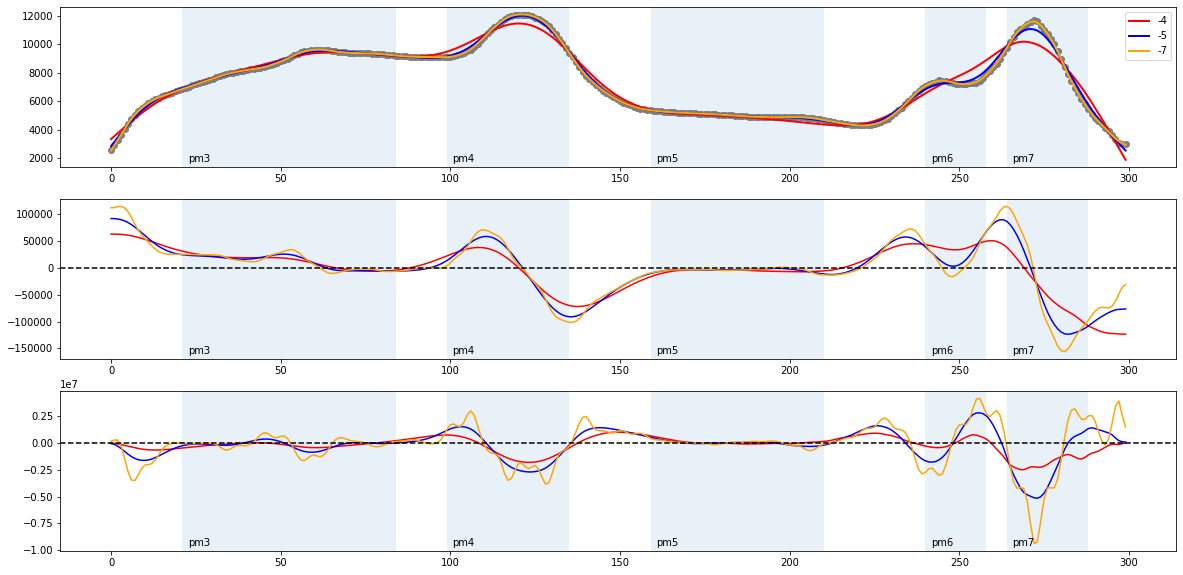

In [946]:
norm = mpl.colors.Normalize(vmin=-10, vmax=-5)
cmap = cm.inferno
newcmp = ListedColormap(cm.inferno(np.linspace(0, 0.8, 256)))
m = cm.ScalarMappable(norm=norm, cmap=newcmp)

j = j + 1

regions = {
    'pm3': [.07, .28],
    'pm4': [.33, .45],
    'pm5': [.53, .70],
    'pm6': [.80, .86],
    'pm7': [.88, .96],
}

prof_len = unreg_data.shape[-1]
scaled_regions = {
    region: (prof_len * np.asarray(regions[region])).astype(np.int)
    for region in regions.keys()
}

raw = unreg_data.sel(wavelength='410', pair=0)[j]
fig, axes = plt.subplots(3, 1, figsize=(20,10))
axes[0].scatter(np.arange(raw.position.size), raw.values, color='gray')

for i, color in tqdm_notebook([(-4, 'red'), (-5, 'blue'), (-7, 'orange')]):
    sm,basis = profile_processing.smooth_profile_data(raw, smoothing_parameter=10 ** i, nbasis=200)
#     basis.plot(ax=ax)
    axes[0].plot(np.squeeze(sm.data_matrix), linewidth=2, label=f'{i}', color=color)
    axes[1].plot(np.squeeze(sm.derivative().data_matrix), color=color)
    axes[2].plot(np.squeeze(sm.derivative(2).data_matrix), color=color)
axes[0].legend()
axes[1].axhline(0, color='k', linestyle='--')
axes[2].axhline(0, color='k', linestyle='--')
plots.add_regions_to_axis(axes[0], scaled_regions)
plots.add_regions_to_axis(axes[1], scaled_regions)
plots.add_regions_to_axis(axes[2], scaled_regions)

In [775]:
subset_data = data[moving_first.values]
s470,_ = profile_processing.smooth_profile_data(subset_data.sel(wavelength='470', pair=0))
s470 = np.squeeze(s470.data_matrix)

In [844]:
subset_data = data[moving_first.values]
reg_data = profile_processing.register_profiles(subset_data, warp_lam=.01)
s470,_ = profile_processing.smooth_profile_data(subset_data.sel(wavelength='470', pair=0))
s470 = np.squeeze(s470.data_matrix)

r410 = reg_data.sel(wavelength='410',pair=0)
r470 = reg_data.sel(wavelength='470',pair=0)

(array([1800.,   26.,  207.,  213.,  310.,  147.,  100.,  129.,   29.,
          39.]),
 array([ -275.30939545,  1143.22756417,  2561.76452378,  3980.30148339,
         5398.838443  ,  6817.37540261,  8235.91236222,  9654.44932183,
        11072.98628145, 12491.52324106, 13910.06020067]),
 <a list of 10 Patch objects>)

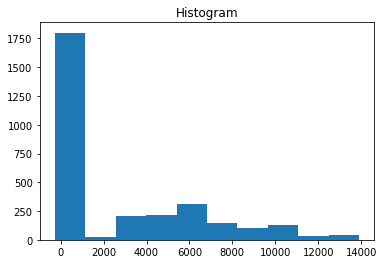

6


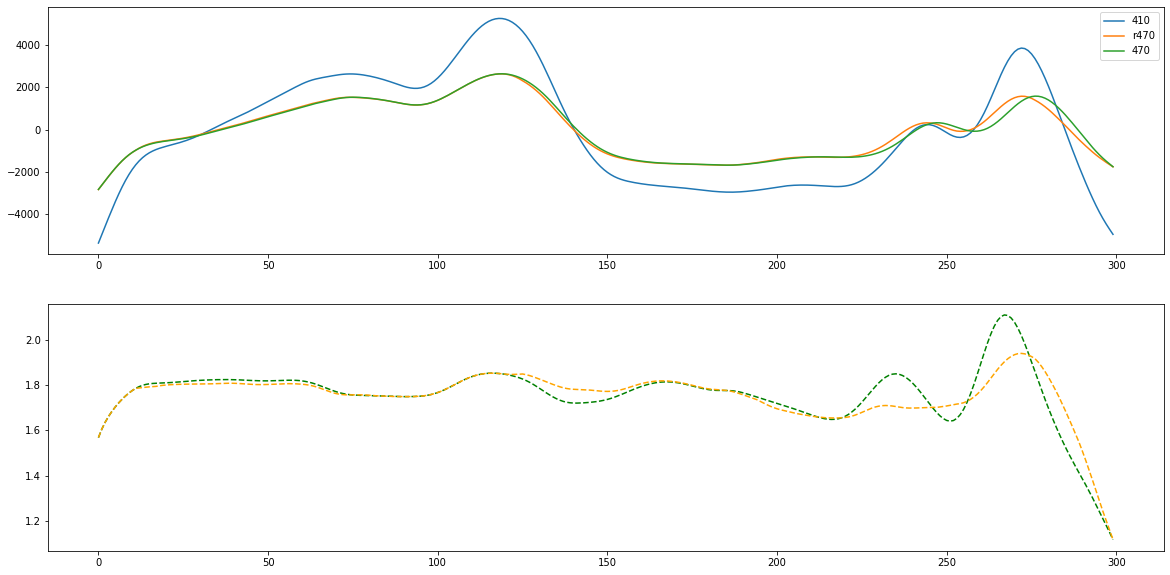

In [848]:
i = np.random.choice(range(len(moving_first)))
fig, axes = plt.subplots(2,1, figsize=(20,10))
axes[0].plot(r410[i]-np.mean(r410[i]), label='410')
axes[0].plot(r470[i]-np.mean(r470[i]), label='r470')
axes[0].plot(s470[i]-np.mean(s470[i]), label='470')
print(i)
axes[0].legend()

axes[1].plot(r410[i].T/s470[i].T, color='green', linestyle='--')
axes[1].plot(r410[i].T/r470[i].T, color='orange', linestyle='--')

In [840]:
def zstd(d, maxis=1, saxis=1):
    return (d-np.mean(d, axis=maxis))/np.std(d, axis=saxis)

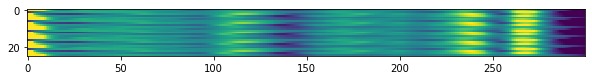

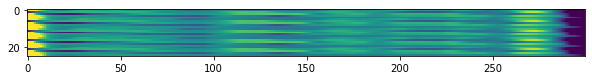

In [843]:
plt.figure(figsize=(10,10))
plt.imshow(zstd(r410/s470))
plt.clim([-2,2])
plt.figure(figsize=(10,10))
plt.imshow(zstd(r410/r470))
plt.clim([-2,2])

In [815]:
r410.shape

(25, 300)

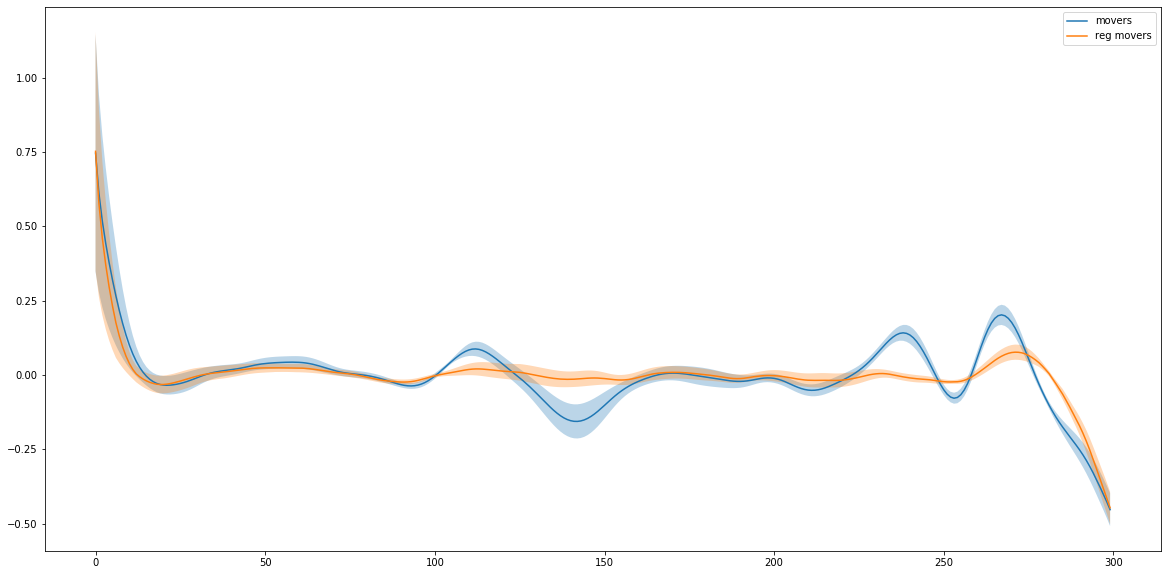

In [793]:
# r_stationary = np.squeeze(r410[stationary]).T / np.squeeze(s470[stationary]).T

# r_movers     = np.squeeze(r410)[movers].T     / np.squeeze(s470)[movers].T
# reg_movers   = np.squeeze(r410)[movers].T     / np.squeeze(r470)[movers].T

r_movers = (r410 / s470).T
reg_movers = (r410 / r470).T

plt.figure(figsize=(20,10))
# plots.plot_profile_avg_with_bounds((r_stationary - np.mean(r_stationary, axis=0)).T, ax=plt.gca(), label='stationary');
plots.plot_profile_avg_with_bounds((r_movers - np.mean(r_movers, axis=0)).T, ax=plt.gca(), label='movers');
plots.plot_profile_avg_with_bounds((reg_movers - np.mean(reg_movers, axis=0)).T, ax=plt.gca(), label='reg movers');
plt.legend()

In [489]:
non_moving_first = summary[(summary.pair == 0) & (summary.posterior == 0)].animal
non_moving_second = summary[(summary.pair == 1) & (summary.posterior == 0)].animal
moving_second = summary[(summary.pair == 1) & (summary.posterior > 0)].animal

movers = np.intersect1d(non_moving_first, moving_second)
stationary = np.intersect1d(non_moving_first, non_moving_second)

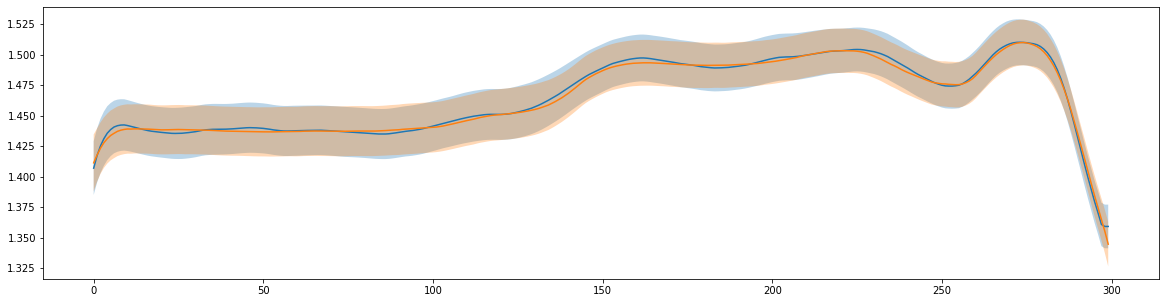

In [497]:
plt.figure(figsize=(20,5))
i = 0
r_raw = np.squeeze((f410/f470).data_matrix)
r_reg = np.squeeze((f410s/f470sr).data_matrix)

plots.plot_profile_avg_with_bounds(r_raw, ax=plt.gca())
# plots.plot_profile_avg_with_bounds(np.squeeze((f410s/f470sr).data_matrix), ax=plt.gca())

plots.plot_profile_avg_with_bounds(r_reg, ax=plt.gca())
# plots.plot_profile_avg_with_bounds(np.squeeze((f410s/f470sr).data_matrix[stationary]), ax=plt.gca())